In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
import prepare as p
import numpy as np
import pandas as pd
np.set_printoptions(threshold=np.inf)

In [12]:
# import data
df = p.loadData("alldata.csv", clean=False, alldata=True)

# remove call records with purpose 'energy'/'family'
df = df[(df.purpose=="support")& ~(df.purpose == 'energy') & ~(df.purpose == 'family')]

In [13]:
import random
df.contact.value_counts()/len(df)
contact = df[df.contact == 1].sample(1000000)
nocontact = df[df.contact == 0].sample(1000000)
sample = pd.concat([contact, nocontact]).sample(2000000)
sample.contact.value_counts()/len(sample)
df = sample

False    0.794072
True     0.205928
Name: contact, dtype: float64

True     0.5
False    0.5
Name: contact, dtype: float64

In [13]:
# target variable
target = df.contact.to_numpy()
# encode target as 0 and 1
target = np.where(target==True, 1, 0)

# predictor variables
# extract columns with categorical data
categorical = df[['dayofweek','hour','month','purpose']]
# extract columns with continuous data
continuous = df[['latitude','longitude']].to_numpy()

In [14]:
# one hot encode categorical data
encode = OneHotEncoder()
oneHotCats = encode.fit_transform(categorical).toarray()

# concatenate one hot encoded data with continous data
data = np.concatenate((oneHotCats, continuous), axis=1)

In [15]:
from sklearn import metrics

def my_custom_loss_func(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    return(metrics.auc(fpr, tpr))

my_scorer = metrics.make_scorer(my_custom_loss_func, greater_is_better=True)

In [17]:
# specify algorithm
from sklearn.ensemble import RandomForestClassifier
algorithm = RandomForestClassifier()

# define paramater space
space = dict()
# space['n_estimators'] = [int(x) for x in np.linspace(start = 200, stop = 2000)]
# space['max_features'] = ['auto', 'sqrt']
space['max_depth'] = [int(x) for x in np.linspace(start = 2, stop = 6)]
# space['min_samples_split'] = [2, 5, 10]
# space['min_samples_leaf'] = [1, 2, 4]
# space['bootstrap'] = [True, False]

# choose number of folds
n_folds = 3

# how many times do you want to sample the paramater space?
n_samples = 20

# perform hyperparameter tuning with randomised grid search, plus
# stratified cross validation
clf = RandomizedSearchCV(estimator=algorithm,
                        n_iter=n_samples,
                        param_distributions=space,
                        cv=n_folds,
                        scoring=my_scorer,
                        random_state=0,
                        n_jobs=4,
                        pre_dispatch='2*n_jobs')

# search for best hyperparameterisation
best_model = clf.fit(data, target)

print('Best PR AUC Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)

# the first column in preds is P(no contact | date, time, etc.)
# the second column in preds is P(contact | data, time, etc.)
preds = best_model.predict_proba(data)
# show first 5 rows of preds
preds[:5]

Best PR AUC Score: 0.5
Best Hyperparameters: {'max_depth': 4}


array([[0.58443034, 0.41556966],
       [0.65547651, 0.34452349],
       [0.65604284, 0.34395716],
       [0.66194905, 0.33805095],
       [0.65779089, 0.34220911]])

In [18]:
import pickle
filename = 'rf_support_model.p'
with open(filename, 'wb') as filehandler:
    pickle.dump(best_model, filehandler)

In [21]:
import pickle
filename = 'rf_support_model.p'
model = pickle.load(open(filename, 'rb'))

In [20]:
def prep(df):
    '''
    Input Pandas data frame.
    Binarise labels, extract columns, one hot encode categorical variables.
    Return targets and data consisting of features as Numpy array.
    '''
    # target variable
    target = df.contact.to_numpy()
    # encode target as 0 and 1
    target = np.where(target==True, 1, 0)

    # predictor variables
    # extract columns with categorical data
    categorical = df[['dayofweek','hour','month']]
    # extract columns with continuous data
    # also normalize if needed
    continuous = normalize(df[['latitude','longitude']].to_numpy())
    
    # one hot encode categorical data
    encode = OneHotEncoder()
    oneHotCats = encode.fit_transform(categorical).toarray()

    # concatenate one hot encoded data with continous data
    data = np.concatenate((oneHotCats, continuous), axis=1)
    
    return (target, data)

In [ ]:
# sample some of the data not used for training
#test_y, test_x = prep(remaining.sample(1000000))

# import data
df = p.loadData("alldata.csv", clean=False, alldata=True)

# remove call records with purpose 'energy'/'family'
df = df[~(df.purpose == 'energy') & ~(df.purpose == 'family')]
test_y, test_x = prep(df)

In [6]:
test_x.shape

(13977762, 43)

In [7]:
pred_y = model.predict_proba(test_x)[:,1]

NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
precision = []
recall = []
ps = []
baseline = test_y.sum()/len(test_y)
for p in np.arange(0,1,0.05):
    classify = np.where(pred_y >= p, 1, 0).flatten()
    tn, fp, fn, tp = confusion_matrix(test_y, classify).ravel()
    precision.append(tp/(tp+fp))
    recall.append(tp/(tp+fn))
    ps.append(p)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ps, precision, label='precision');
plt.plot(ps, recall, label='recall');
plt.plot(ps, [baseline]*len(ps), label='baseline');
plt.xlabel("Classification threshold")
plt.ylabel("Precision/recall")
plt.title("Precision and recall per classifcation threshold \n compared to baseline precision")
plt.legend();

In [ ]:
from sklearn import metrics
prec, rec, thresholds = metrics.precision_recall_curve(test_y, pred_y.ravel(), pos_label=1)
plt.plot(prec, rec)
pr_auc = metrics.auc(rec, prec)
plt.xlabel("Precision");
plt.ylabel("Recall");
plt.title("Precision recall curve with AUC " + str(pr_auc)[:6]);

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y.ravel())
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr);
plt.plot([0,1],[0,1], '--', color='grey')
plt.xlabel("False positive rate");
plt.ylabel("True positive rate");
plt.title("ROC curve with AUC " + str(auc)[:6]);

In [ ]:
import pickle
filename = 'svc_health_only.p'
with open(filename, 'wb') as filehandler:
    pickle.dump(preds, filehandler)

In [ ]:
filename = 'svc_health_only_target.p'
with open(filename, 'wb') as filehandler:
    pickle.dump(target, filehandler)

In [11]:
contact_preds = preds[:,1]
classify = np.where(preds >= 0.5, 1, 0).flatten()
# baseline performance where the company assumes everyone will be contactable
classify.sum()
baseline = target.sum()/len(target)

2000000

In [13]:
from sklearn.metrics import confusion_matrix
classify = np.where(contact_preds >= 0.5, 1, 0).flatten()
tn, fp, fn, tp = confusion_matrix(target, classify).ravel()
tn
fp
fn
tp
tp/(tp+fp)
tp/(tp+fn)
tp+fp

precision = []
recall = []
ps = []
for p in np.arange(0,1,0.05):
    classify = np.where(contact_preds >= p, 1, 0).flatten()
    tn, fp, fn, tp = confusion_matrix(target, classify).ravel()
    precision.append(tp/(tp+fp))
    recall.append(tp/(tp+fn))
    ps.append(p)

711982

288018

426444

573556

0.6657071824358674

0.573556

861574

<ipython-input-13-262541c1fb97>:18: RuntimeWarning: invalid value encountered in long_scalars
  precision.append(tp/(tp+fp))


Text(0.5, 0, 'threshold')

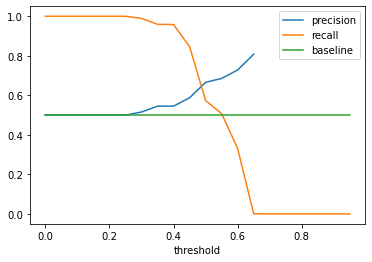

In [17]:
import matplotlib.pyplot as plt
plt.plot(ps, precision, label='precision');
plt.plot(ps, recall, label='recall');
plt.plot(ps, [baseline]*len(ps), label='baseline');
plt.xlabel("threshold")
plt.legend();
plt.savefig("rf_all_pr.png")

In [10]:
import pickle
filename = 'rf_health.p'
with open(filename, 'wb') as filehandler:
    pickle.dump(preds, filehandler)

In [11]:
filename = 'rf_health_target.p'
with open(filename, 'wb') as filehandler:
    pickle.dump(target, filehandler)

In [17]:
import pickle
filename = 'rf_all.p'
model = pickle.load(open(filename, "rb"))